True

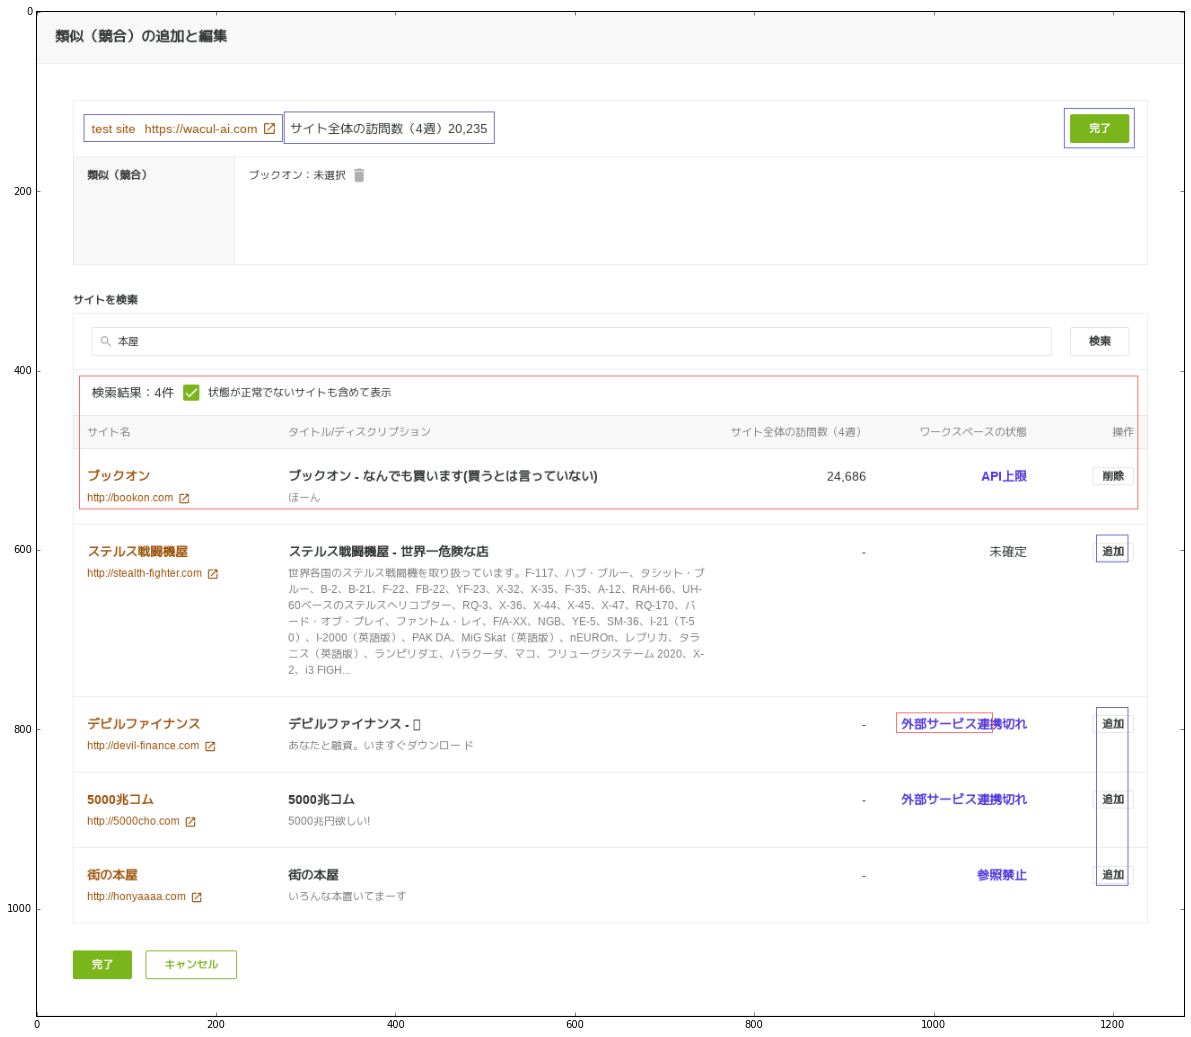

In [111]:
import cv2, matplotlib, math
# import  numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# extract bounding recangular from keypoint list
def create_rects(keypoints, padding):
    rects = []
    for kp in keypoints:
        #out_img = cv2.drawKeypoints(out_img, kp, None, flags=2)
        xx1 = min([int(p.pt[0]) for p in kp])
        xx2 = max([int(p.pt[0]) for p in kp])
        yy1 = min([int(p.pt[1]) for p in kp])
        yy2 = max([int(p.pt[1]) for p in kp])
        if xx1 < xx2:
            x1 = xx1
            x2 = xx2
        else:
            x2 = xx1
            x1 = xx2
        if yy1 < yy2:
            y1 = yy1
            y2 = yy2
        else:
            y2 = yy1
            y1 = yy2
        x1 -= rect_padding
        x2 += rect_padding
        y1 -= rect_padding
        y2 += rect_padding
        rects.append((x1, y1, x2, y2))
    return rects

# detect to intersect 2 recangulars
def intersect(r1, r2):
    mx1 = max(r1[0], r2[0])
    mx2 = min(r1[2], r2[2])
    my1 = max(r1[1], r2[1])
    my2 = min(r1[3], r2[3])
    result = mx1 < mx2 and my1 < my2
    connected_rect = (min(r1[0], r2[0]), min(r1[1], r2[1]), max(r1[2], r2[2]), max(r1[3], r2[3]))
    return (result, connected_rect)

%matplotlib inline

img1=cv2.imread('img/actual/unittest/tuner-similar-ws-components/SimilarSiteAddModalComponent ga check should change valid message to dailyLimitExceeded message if the fetch status is dailyLimitExceeded.png')
img2=cv2.imread('img/expected/unittest/tuner-similar-ws-components/SimilarSiteAddModalComponent ga check should change valid message to dailyLimitExceeded message if the fetch status is dailyLimitExceeded.png')

akaze = cv2.AKAZE_create()
kp1, des1 = akaze.detectAndCompute(img1, None)
kp2, des2 = akaze.detectAndCompute(img2, None)
bf = cv2.BFMatcher(2)
matches = bf.knnMatch(des1, des2, k=3)
ratio = 0.5

good = [ ]
for m, n, p in matches:
    if m.distance < ratio * n.distance:
        good.append([m])
# print(len(matches), len(kp1), len(kp2), len(good))

dy=[]
matt=[]
gk1 = []
ngk1 = []
gg = []
dxw, dyw, wy=(100, 1000, 10.0)
for g in good:
    x1, y1 = kp1[g[0].queryIdx].pt
    x2, y2 = kp2[g[0].trainIdx].pt
    if abs(x1-x2) < 100:
        dy.append({'dx': x2-x1, 'dy': y2-y1})
        matt.append([x1, x2, wy*y1, wy*y2, dxw * (x1 - x2), dyw*(y1-y2)])
        gg.append(g)
        gk1.append(kp1[g[0].queryIdx])
        
for k in kp1:
    if not k in gk1:
        ngk1.append(k)

num_k = 6
npmat=np.array(matt)
criteria =(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv2.kmeans(np.float32(npmat), num_k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

cgg = [[] for i in range(num_k)]

i = 0
for l in label:
    cgg[l[0]].append(gg[i])
    i = i + 1

kp1x = [[kp1[g[0].queryIdx] for g in cg] for cg in cgg]
kp2x = [[kp2[g[0].trainIdx] for g in cg] for cg in cgg]


out_img = img1

diff_rects = []
rects1 = create_rects(kp1x, 10)
rects2 = create_rects(kp2x, 10)

for i in range(len(rects1)):
    r1, r2 = (rects1[i], rects2[i])
    x1, y1, x2, y2 = (r1[0], r1[2], r2[0], r2[2])
    w1, h1 = (r1[2] - r1[0], r1[3] - r1[1])
    w2, h2 = (r2[2] - r2[0], r2[3] - r2[1])
    imgr1 = img1[r1[1]:r1[3], r1[0]:r1[2]]
    imgr2 = img2[r2[1]:r2[3], r1[0]:r1[2]]
    result = np.allclose(imgr1, imgr2)
    if not result:
        diff_rects.append(r1)
    
for r in diff_rects:
    x1, y1, x2, y2 = r
    out_img = cv2.rectangle(out_img, (x1, y1), (x2, y2), (255, 100, 100), 1)

    
rest_kp = []
for kp in ngk1:
    result = True
    for box in rects1:
        in_box = kp.pt[0] > box[0] and kp.pt[0] < box[2] and kp.pt[1] > box[1] and kp.pt[1] < box[3]
        result = result and (not in_box)
    if result:
        rest_kp.append(kp)

matt = []
for kp in rest_kp:
    matt.append([kp.pt[0], kp.pt[1]])
num_k = 15
npmat=np.array(matt)
criteria =(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv2.kmeans(np.float32(npmat), num_k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

kps = [ [] for i in range(num_k)]
i = 0
for l in label:
    kps[l[0]].append(rest_kp[i])
    i += 1
    
rects = create_rects(kps, 10)

connected_pairs = [[] for i in range(len(rects))]
for i in range(len(rects)):
    r1 = rects[i]
    for j in range(i + 1, len(rects)):
        r2 = rects[j]
        result, connected = intersect(r1, r2)
        if result:
            connected_pairs[i].append(j)
            rects[i] = connected
            r1 = connected
            rects[j] = connected

connected_rects = []
for i in range(len(connected_pairs)):
    if len(connected_pairs[i]) == 0:
        connected_rects.append(rects[i])
        
for rect in connected_rects:
    x1, y1, x2, y2 = rect
    out_img = cv2.rectangle(out_img, (x1, y1), (x2, y2), (100, 100, 200), 1)

#out_img = cv2.drawKeypoints(out_img, rest_kp, None, flags=2)
plt.figure(figsize=(24, 18))
plt.imshow(out_img)

cv2.imwrite('out.png', out_img)